In [1]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception
from tensorflow.keras import preprocessing
import tensorflow_datasets as tfds

from data_loader import StanfordDogLoader

In [2]:
batch_size = 32
img_height = 224
img_width = 224

loader = StanfordDogLoader()

_, _, test_ds_original = loader.load()

[INFO] Fetched 20580 images
[INFO] Found 120 classes
[INFO] The first ten classes are
['n02085620-Chihuahua' 'n02085782-Japanese_spaniel'
 'n02085936-Maltese_dog' 'n02086079-Pekinese' 'n02086240-Shih-Tzu'
 'n02086646-Blenheim_spaniel' 'n02086910-papillon' 'n02087046-toy_terrier'
 'n02087394-Rhodesian_ridgeback' 'n02088094-Afghan_hound']
[INFO] Image count per class
[152 185 252 149 214 188 196 172 172 239 175 195 187 171 159 153 157 148
 151 218 182 187 188 196 151 200 232 160 155 164 182 172 179 169 172 185
 164 157 197 202 202 197 196 180 182 154 157 155 158 206 183 156 169 186
 152 151 150 171 167 152 154 161 155 153 152 150 159 150 159 151 150 150
 154 150 150 152 153 154 169 157 153 150 150 152 152 150 184 168 218 151
 202 151 156 152 159 156 170 150 178 192 150 209 200 210 195 213 218 219
 196 158 153 181 155 151 155 159 155 156 150 169]
[INFO] The dataset split is
- Train 14499
- Val 4072
- Test 2009


In [3]:
for img, label in test_ds_original.take(10):
    print(label)

tf.Tensor(91, shape=(), dtype=int64)
tf.Tensor(119, shape=(), dtype=int64)
tf.Tensor(50, shape=(), dtype=int64)
tf.Tensor(57, shape=(), dtype=int64)
tf.Tensor(81, shape=(), dtype=int64)
tf.Tensor(103, shape=(), dtype=int64)
tf.Tensor(88, shape=(), dtype=int64)
tf.Tensor(109, shape=(), dtype=int64)
tf.Tensor(20, shape=(), dtype=int64)
tf.Tensor(63, shape=(), dtype=int64)


In [4]:
from tensorflow.keras.applications import xception

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(img, label = None):
    resized = preprocessing.image.smart_resize(img, [img_height, img_width])
    final = xception.preprocess_input(resized)
    return final, label

X_ds = test_ds_original \
    .map(preprocess, num_parallel_calls=AUTOTUNE) \
    .map(lambda X, y: X, num_parallel_calls=AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(AUTOTUNE)

y_ds = test_ds_original \
    .map(preprocess, num_parallel_calls=AUTOTUNE) \
    .map(lambda X, y: y, num_parallel_calls=AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(AUTOTUNE)

In [5]:
model = keras.models.load_model("models/dog_v5.h5")
prob_model = tf.keras.Sequential([model, tf.keras.layers.Softmax(axis=1)])

In [6]:
pred = prob_model.predict(X_ds)
pred.shape

(2009, 120)

In [7]:
def parse_pred(predictions, top_k = 3):
    ind = np.argpartition(pred, -top_k, axis=1)[:,-top_k:]
    probs = np.take_along_axis(predictions, ind, axis=1)
    sort_ind = np.take_along_axis(ind, np.argsort(probs, axis=1), axis=1)
    probs = np.take_along_axis(predictions, sort_ind, axis=1) * 100
    class_names = loader.norm_class_names[sort_ind.flat].reshape(-1, top_k)
    return probs, class_names

probs, class_names = parse_pred(pred, top_k=5)

Probabilities: [7.4299527e-03 1.1035010e-02 2.6608115e-02 1.7219908e+00 9.8193123e+01]
Class names: ['French bulldog' 'Great Dane' 'American Staffordshire terrier'
 'bull mastiff' 'boxer']
True Class: boxer


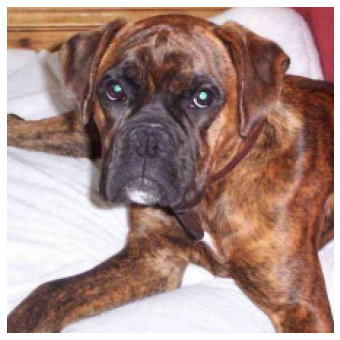

Probabilities: [ 2.460359   4.1897354  4.9393616  5.1760697 66.56478  ]
Class names: ['whippet' 'African hunting dog' 'Mexican hairless' 'Eskimo dog' 'dhole']
True Class: African hunting dog


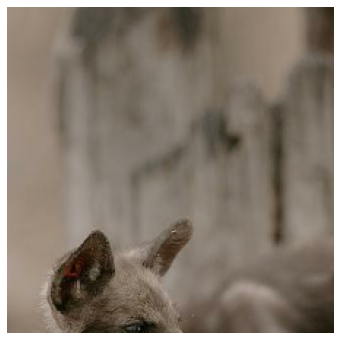

Probabilities: [2.7212914e-02 4.5633163e-02 7.7474155e-02 1.0981823e-01 9.9674988e+01]
Class names: ['Lhasa' 'briard' 'Yorkshire terrier' 'Australian terrier' 'silky terrier']
True Class: silky terrier


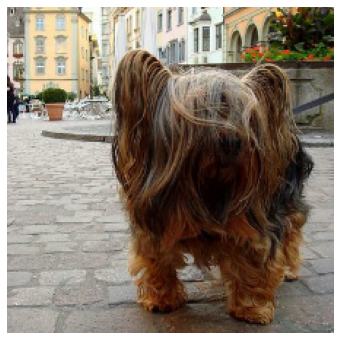

Probabilities: [ 0.31328648  0.3530889   0.57929     7.987907   89.17624   ]
Class names: ['pug' 'black-and-tan coonhound' 'German short-haired pointer'
 'flat-coated retriever' 'Labrador retriever']
True Class: Labrador retriever


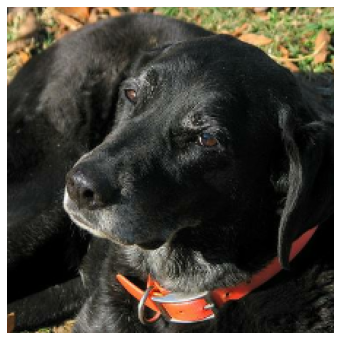

Probabilities: [ 0.0744531   0.11047063  2.680823   44.84523    51.563896  ]
Class names: ['Tibetan terrier' 'Bernese mountain dog' 'English springer'
 'Border collie' 'collie']
True Class: Border collie


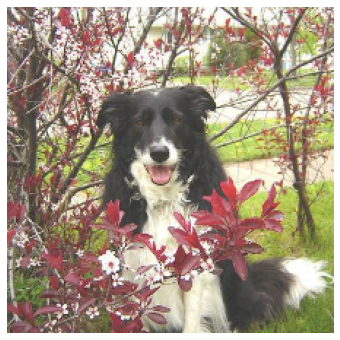

Probabilities: [1.2301819e-02 1.3808073e-02 5.3862348e-02 1.1147588e-01 9.9752861e+01]
Class names: ['Afghan hound' 'Pekinese' 'Newfoundland' 'Tibetan mastiff' 'Leonberg']
True Class: Leonberg


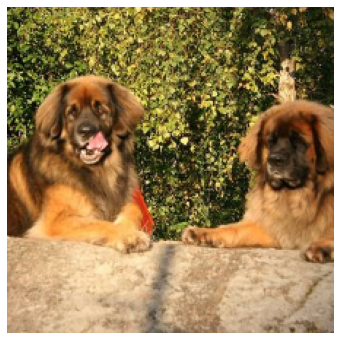

Probabilities: [ 1.189158   1.3727576  2.141209   2.2599957 87.8136   ]
Class names: ['Greater Swiss Mountain dog' 'Cardigan' 'Pembroke' 'Appenzeller'
 'Bernese mountain dog']
True Class: Bernese mountain dog


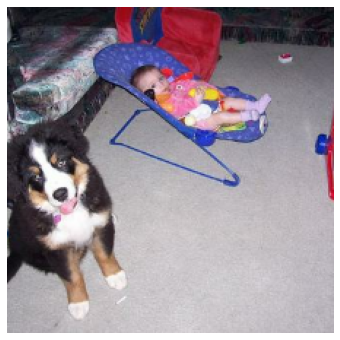

Probabilities: [4.4459756e-03 6.5303138e-03 6.7617269e-03 5.7268932e-02 9.9879471e+01]
Class names: ['Pekinese' 'German shepherd' 'Pomeranian' 'Norwegian elkhound' 'keeshond']
True Class: keeshond


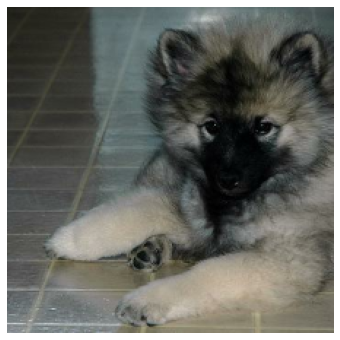

Probabilities: [ 0.33348688  0.34964046  1.4635906   7.3721623  90.35247   ]
Class names: ['toy terrier' 'Boston bull' 'basenji' 'whippet' 'Italian greyhound']
True Class: Italian greyhound


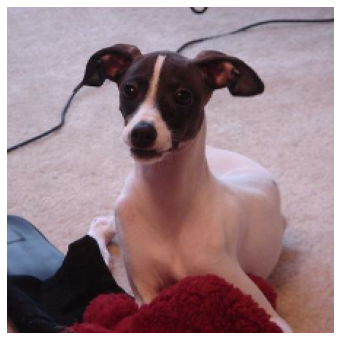

Probabilities: [ 0.41442043  0.5853477   0.62445337  0.6379856  96.99855   ]
Class names: ['Doberman' 'Rottweiler' 'black-and-tan coonhound' 'flat-coated retriever'
 'Gordon setter']
True Class: Gordon setter


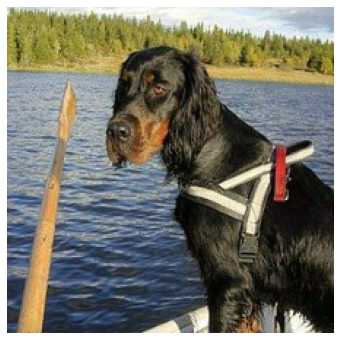

Probabilities: [ 0.09441864  0.14594644  0.18924439 13.34901    86.00275   ]
Class names: ['Pembroke' 'silky terrier' 'Norfolk terrier' 'Norwich terrier'
 'Australian terrier']
True Class: Australian terrier


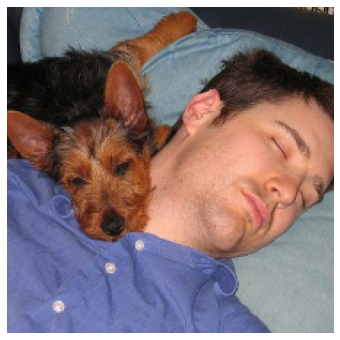

Probabilities: [8.1289969e-02 5.5637026e-01 1.4297473e+00 7.9944792e+00 8.9611229e+01]
Class names: ['bloodhound' 'Walker hound' 'bluetick' 'beagle' 'basset']
True Class: bluetick


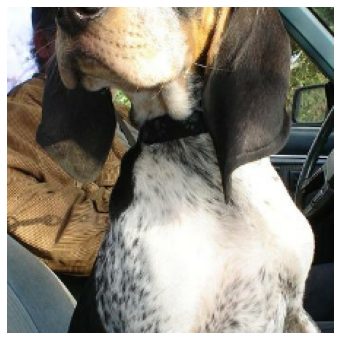

Probabilities: [ 0.47589195  0.5217629   0.7951117  12.925424   84.573006  ]
Class names: ['briard' 'affenpinscher' 'Bouvier des Flandres' 'giant schnauzer'
 'Newfoundland']
True Class: affenpinscher


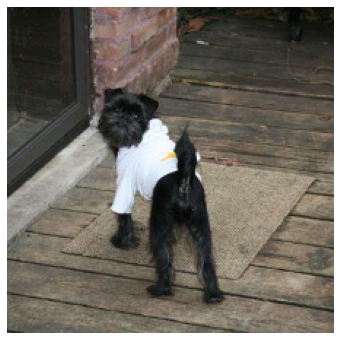

Probabilities: [2.3559880e-02 4.7538534e-02 1.9040057e-01 2.9345182e-01 9.9387428e+01]
Class names: ['Irish water spaniel' 'Kerry blue terrier' 'standard poodle'
 'flat-coated retriever' 'curly-coated retriever']
True Class: curly-coated retriever


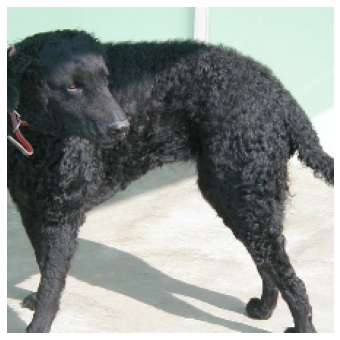

Probabilities: [4.2636604e-03 4.6044961e-03 2.7829075e-01 3.8209420e-01 9.9300850e+01]
Class names: ['Sealyham terrier' 'Kerry blue terrier' 'giant schnauzer'
 'miniature schnauzer' 'standard schnauzer']
True Class: standard schnauzer


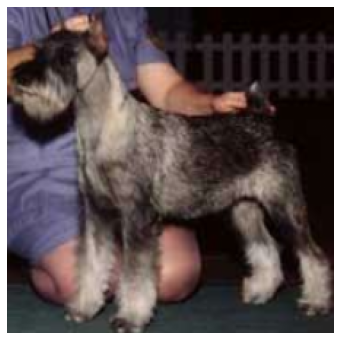

Probabilities: [ 0.44809213  1.0624374   1.7652088  44.043217   51.810635  ]
Class names: ['groenendael' 'Irish water spaniel' 'Labrador retriever'
 'curly-coated retriever' 'flat-coated retriever']
True Class: curly-coated retriever


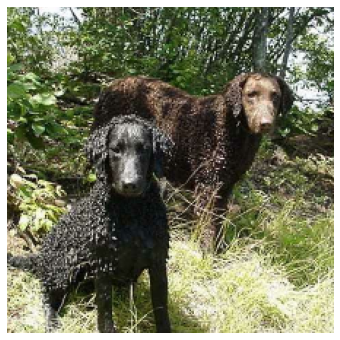

Probabilities: [ 0.25224924  5.9927335  22.556536   27.088789   43.21009   ]
Class names: ['bluetick' 'English foxhound' 'Walker hound' 'beagle' 'basset']
True Class: Walker hound


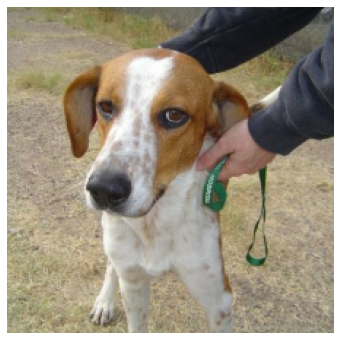

Probabilities: [ 0.37387854  2.137878   11.941179   32.023994   52.19835   ]
Class names: ['briard' 'affenpinscher' 'Shih-Tzu' 'Lhasa' 'Tibetan terrier']
True Class: Shih-Tzu


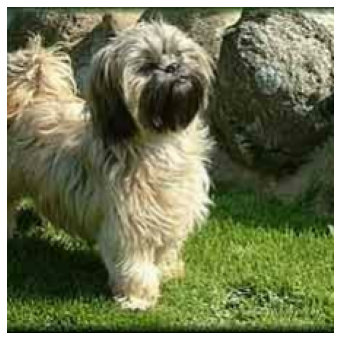

Probabilities: [1.9902546e-02 2.5203316e-02 3.9292678e-02 2.6514643e-01 9.9638054e+01]
Class names: ['West Highland white terrier' 'Lhasa' 'miniature poodle' 'toy poodle'
 'Maltese dog']
True Class: Maltese dog


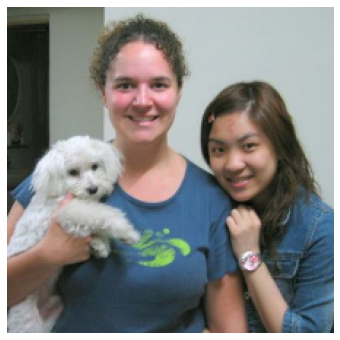

Probabilities: [ 0.10525636  0.22571701  0.38221067 11.475581   87.64219   ]
Class names: ['basenji' 'toy terrier' 'Great Dane' 'whippet' 'Italian greyhound']
True Class: Italian greyhound


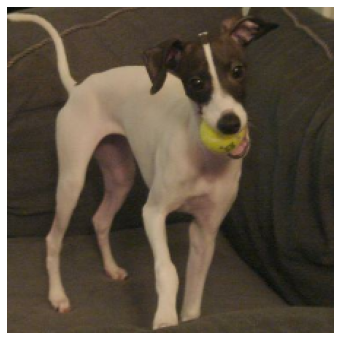

In [8]:
for X_batch, y_batch in zip(X_ds, y_ds):
    for i in range(20):
        print("Probabilities:", probs[i])
        print("Class names:", class_names[i])
        print("True Class:", loader.norm_class_names[y_batch[i].numpy()])
        plt.figure(figsize=[6,6])
        plt.imshow(X_batch[i] / 2 + 0.5)
        plt.axis("off")
        plt.show()
    break

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

y_ds = test_ds_original.map(lambda X, y: y)
y_true = np.fromiter(y_ds, dtype=np.int64)
y_pred = np.argmax(pred, axis=1)

In [10]:
print(classification_report(y_true, y_pred, target_names=loader.class_names))

                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.83      0.67      0.74        15
              n02085782-Japanese_spaniel       0.94      0.83      0.88        18
                   n02085936-Maltese_dog       0.78      0.84      0.81        25
                      n02086079-Pekinese       0.79      0.79      0.79        14
                      n02086240-Shih-Tzu       0.65      0.81      0.72        21
              n02086646-Blenheim_spaniel       0.94      0.94      0.94        18
                      n02086910-papillon       0.89      0.89      0.89        19
                   n02087046-toy_terrier       0.64      0.53      0.58        17
           n02087394-Rhodesian_ridgeback       0.74      0.82      0.78        17
                  n02088094-Afghan_hound       0.96      0.96      0.96        23
                        n02088238-basset       0.79      0.88      0.83        17
               

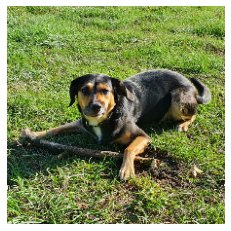

In [11]:
sammy = cv2.imread("data/sammy.JPG")
sammy = cv2.cvtColor(sammy, cv2.COLOR_BGR2RGB)
sammy, _ = preprocess(sammy)
plt.imshow(sammy / 2 + 0.5)
plt.axis("off")
plt.show()

In [12]:
sammy_tensor = tf.constant(sammy)
sammy_tensor = tf.expand_dims(sammy_tensor, axis=0)
pred = prob_model.call(sammy_tensor)
pred.shape

TensorShape([1, 120])

In [13]:
probs, class_names = parse_pred(pred.numpy(), top_k=6)
print(*probs.flatten())
print(" || ".join(class_names.flatten()))

0.60182786 4.3991785 12.443642 15.739152 25.415588 37.939007
Airedale || beagle || bluetick || bloodhound || black-and-tan coonhound || Rottweiler
